El objetivo es mirar las imágenes para ver si se ve algo raro (ej: están distorsionadas, etc.)

In [1]:
import dicom2nifti
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import SimpleITK as sitk # para calcular rangos
import numpy as np
import io
from PIL import Image
import random
import sys
import pandas as pd
import math
import numpy as np
from nilearn import plotting

In [2]:
MAX_IMAGES = 5 # cant de imágenes máxima que muestra de cada tipo

In [3]:
sys.path.append("/Users/hugom/PET-IA/src")

In [4]:
from datasets import ADNIDataset, FleniMyriamDataset, BaseDataset
from transforms import TransformGridImage, Transform3DImage, ToLabelOutputConfigurable
import torch
import torchvision
from torchvision import transforms, utils, models, datasets

In [5]:
def getAllImageIds():
    ids = []
    paths = list(Path('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3').rglob('*.nii'))
    for path in paths:
        ids.append(os.path.split(os.path.split(path)[0])[1])
    return ids

In [6]:
def logDebug(str):
    True # ignore

In [7]:
def show_old(img):
    npimg = img.numpy()
    v_min = npimg.min() # required b/c imgshow accepts only in interval 0,1
    v_max = npimg.max()
    newimg = (np.transpose(npimg, (1, 2, 0)) - v_min) / (v_max - v_min)
    plt.imshow(newimg, interpolation='nearest')

In [8]:
def show(im_data, mean, std):

    dpi = mpl.rcParams['figure.dpi']
    channels, height, width = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize = figsize)
    
    # Create a figure of the right size with one axes that takes up the full figure
    # fig = plt.figure(figsize=figsize)
    #ax = fig.add_axes([0, 0, 1, 1])
    
    # Display the image.
    vmin = mean - 5 * std
    vmax = mean + 5 * std
    ax.imshow(im_data[0], cmap='gray')


    # Remove the left and bottom numbers
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # Remove the axis
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Remove the black lines
    ax.axis('off')
    
    plt.show()

In [9]:
def show_images(dataloader, mean, std):
    i = 0
    for images, labels in dataloader:
        image = images[0]
        label = labels[0]
        show(image, mean, std)
        # print(label)
        i = i + 1
        if i > MAX_IMAGES:
            break

# ADNI

In [21]:
mean = 0.26102542877197266
std = 0.46347398656747363

In [22]:
means = [mean, mean, mean]
stds = [std, std, std]

df = pd.DataFrame(getAllImageIds(), columns = ["ImageDataID"])
df['Group'] = 'AD' # Fake, it doesn't matter

dataAugmentation = {}
adniTransforms = torchvision.transforms.Compose([
    TransformGridImage(**dataAugmentation),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(means, stds)
])
dataset = ADNIDataset('adni', df, '/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3', indexOffset = 0, transform = adniTransforms, truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

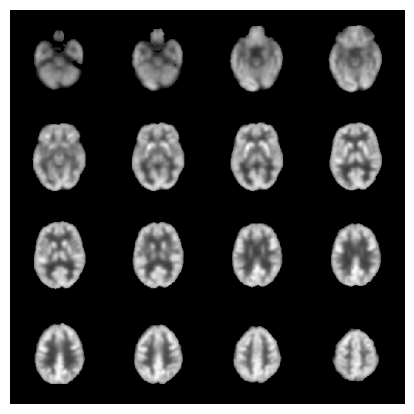

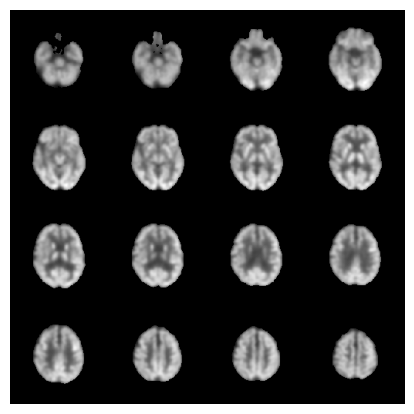

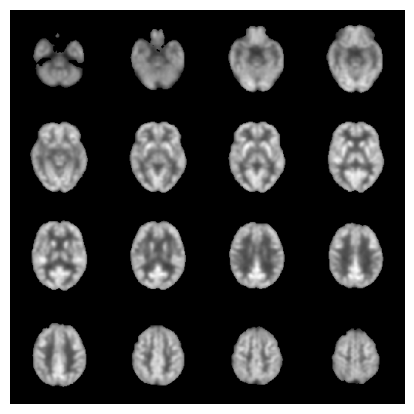

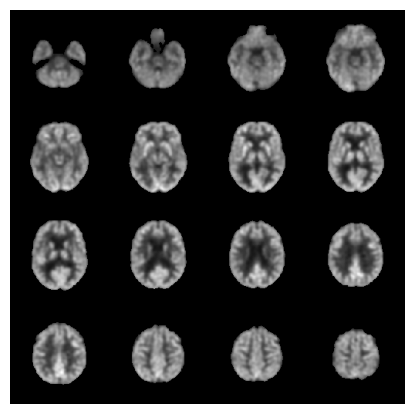

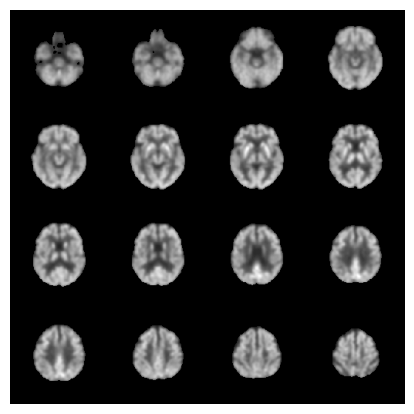

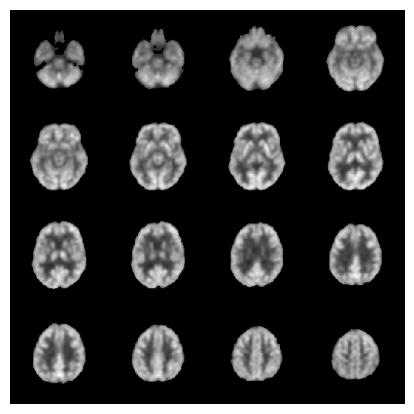

In [23]:
show_images(dataloader, mean, std)

# Fleni (Myriam)

In [130]:
mean = 3364.60595703125
std = 7271.6721598267895

In [131]:
fleniValDatasetCSV = "/Users/hugom/PET-IA/Sets/fleni-myriam-curated.csv"
fleniImagesFolder = "/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed3"
df = pd.DataFrame(getAllImageIds(), columns = ["ImageDataID"])
df['Group'] = 'AD' # Fake, it doesn't matter
means = [mean, mean, mean]
stds = [std, std, std]
dataAugmentation = {}
fleniTransforms = torchvision.transforms.Compose([
    TransformGridImage(**dataAugmentation),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(means, stds)
])
fleniDataset = FleniMyriamDataset('fleni', '/Users/hugom/PET-IA/Sets/fleni-myriam-curated.csv', '/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed3', transform = fleniTransforms)
fleniDataloader = torch.utils.data.DataLoader(fleniDataset, batch_size=1, shuffle=True, num_workers=0)

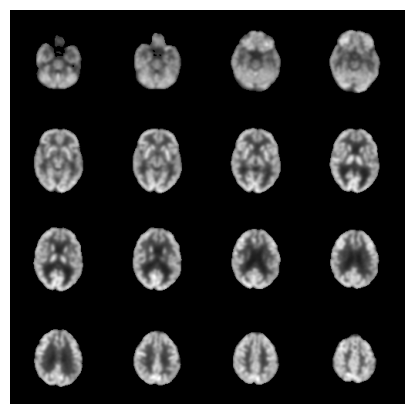

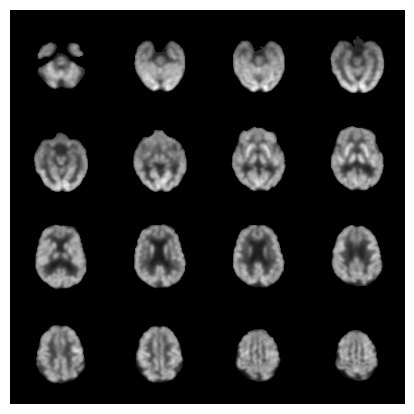

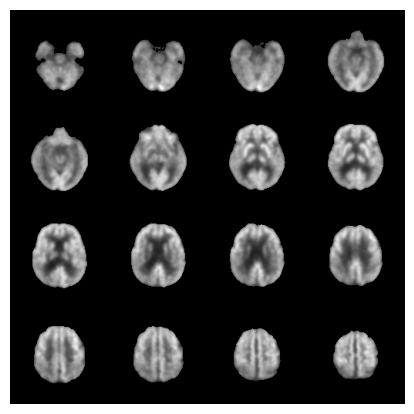

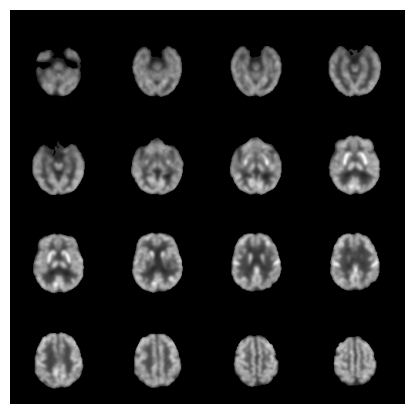

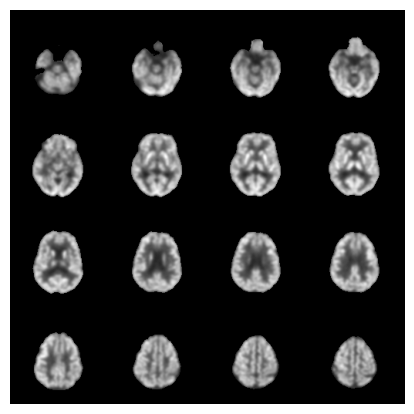

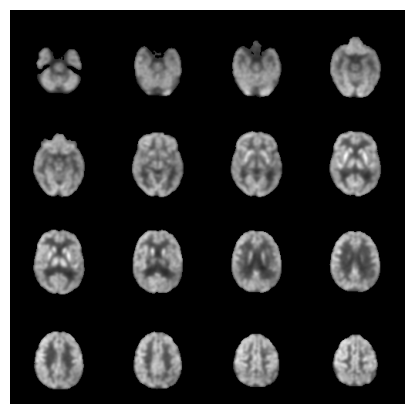

In [132]:
show_images(fleniDataloader)

# Chinese

In [133]:
mean = 0.19838069379329681
std = 0.40906781690739724

In [134]:
csvFile = '/Users/hugom/PET-IA/Sets/chinese.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/chinese-preprocessed'
means = [mean, mean, mean]
stds = [std, std, std]
ebrainsTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(means, stds)
])
dicti = {
    "AD": 1,
    "CN": 0
}
dataset = BaseDataset('chinese', csvFile, imagesFolder, studyIDLabel = 'SubjectID', transform = ebrainsTransforms, truthLabel = 'Diagnosis')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

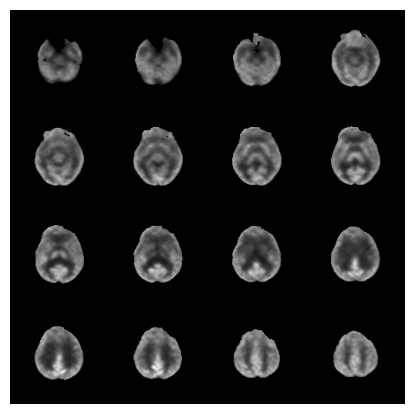

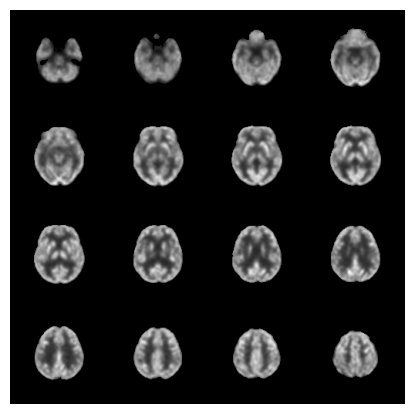

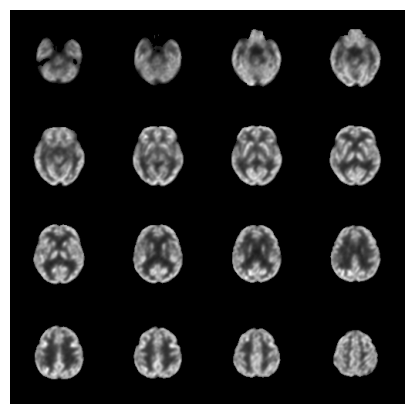

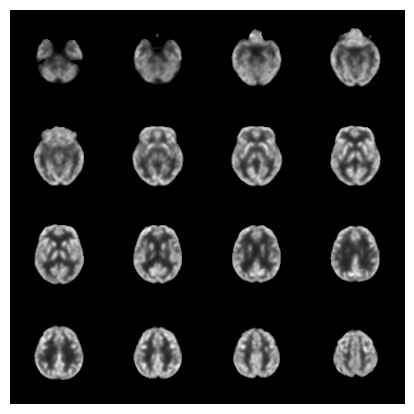

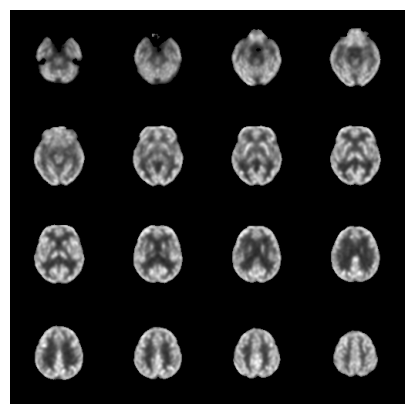

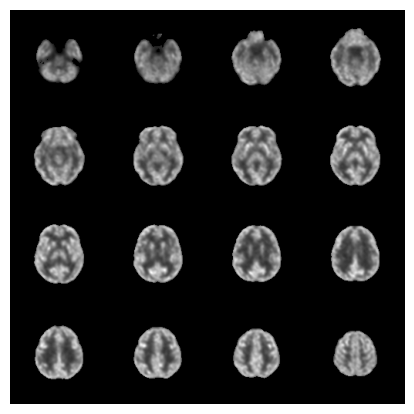

In [135]:
show_images(dataloader)

# Fleni60

In [136]:
mean = 3864.730224609375
std = 8282.332521699427
csvFile = '/Users/hugom/PET-IA/Sets/fleni-PET_clasificados60.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed4'
ebrainsTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([mean, mean, mean], [std, std, std])
])
dicti = {
    "AD": 1,
    "non-AD": 0
}
dataset = BaseDataset('fleni60', csvFile, imagesFolder, studyIDLabel = 'anon_id', transform = ebrainsTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Conclusion PET')
fleniDataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

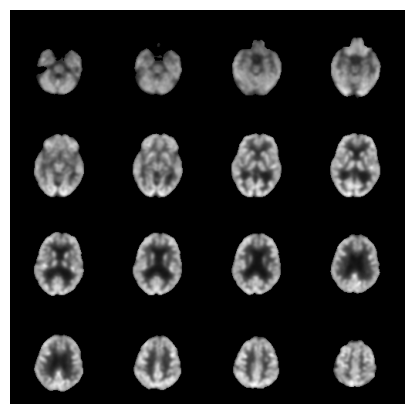

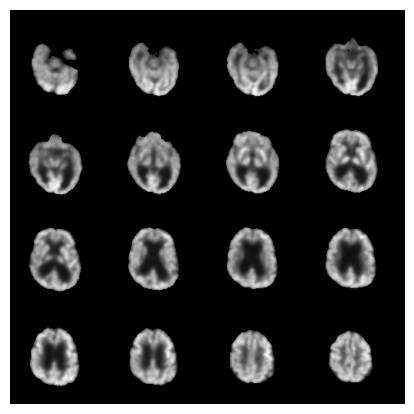

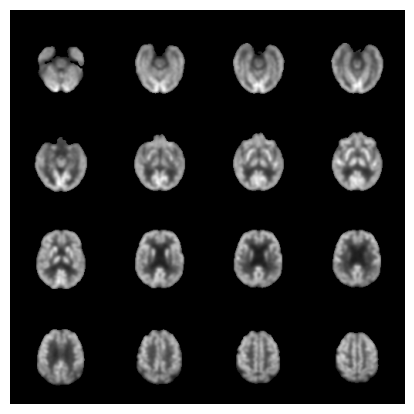

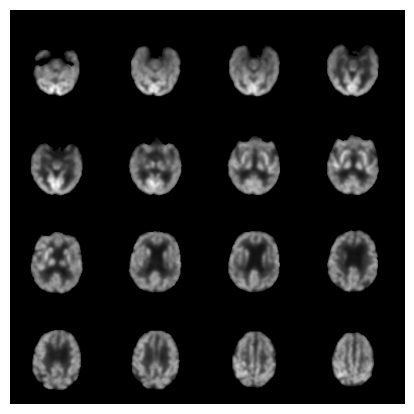

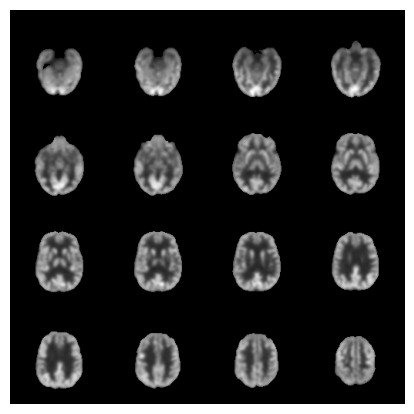

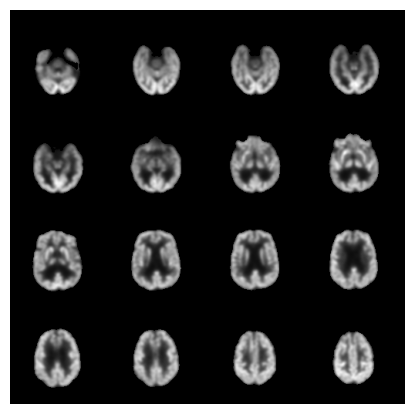

In [137]:
show_images(fleniDataloader)

# Mérida

In [138]:
mean = 2300.842041015625
std = 4192.4441558594435

In [139]:
tsvFile = '/Users/hugom/PET-IA/Full-DBs/ines-merida-db/pool/DM/TEP/CERMEP_MXFDG/BASE/DATABASE_SENT/ALL/participants.tsv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/merida-preprocessed'
dicti = {
    "AD": 1,
    "non-AD": 0
}
csv = pd.read_table(tsvFile, index_col = False)
csv['Group'] = 'non-AD'
meridaTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([mean, mean, mean], [std, std, std])
])
dataset = BaseDataset('merida', csv, imagesFolder, studyIDLabel = 'participant_id', transform = meridaTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

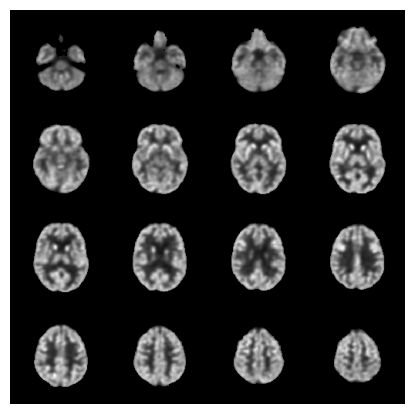

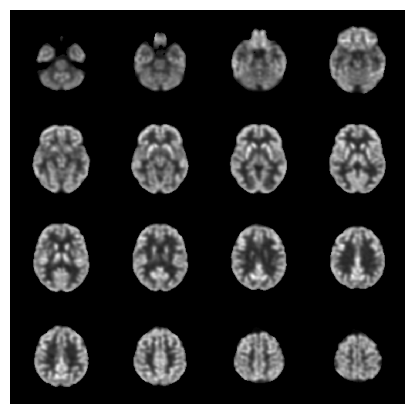

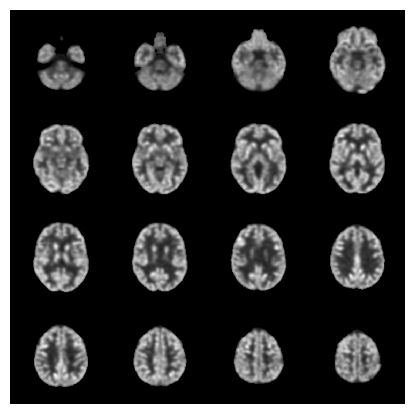

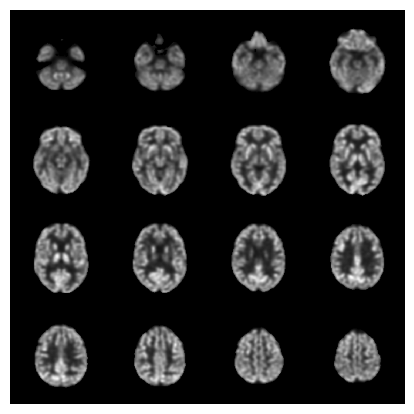

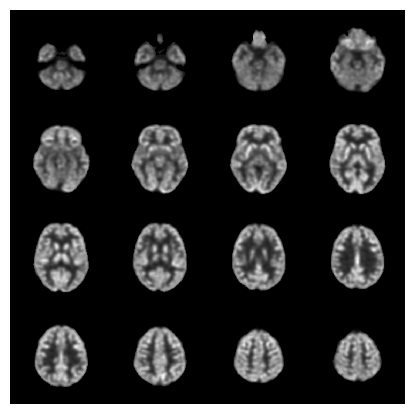

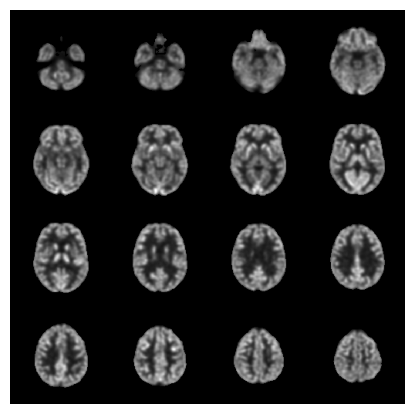

In [140]:
show_images(dataloader)

# Oasis3 (smoothed)

In [141]:
mean = 3374.4560546875
std = 7053.744253940597
csvFile = '/Users/hugom/PET-IA/Sets/oasis3.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/oasis3-preprocessed'
oasisTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([mean, mean, mean], [std, std, std])
])
dicti = {
    "AD": 1,
    "CN": 0
}
csv = pd.read_csv(csvFile)
csv['Group'] = 'CN'
dataset = BaseDataset('oasis3', csv, imagesFolder, studyIDLabel = 'StudyID', transform = oasisTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

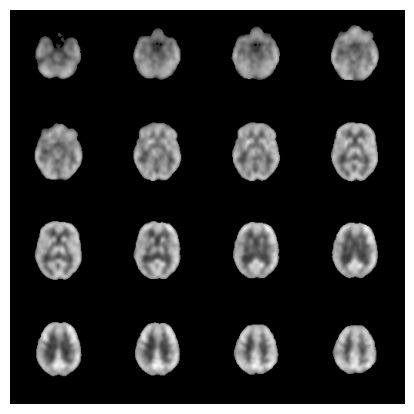

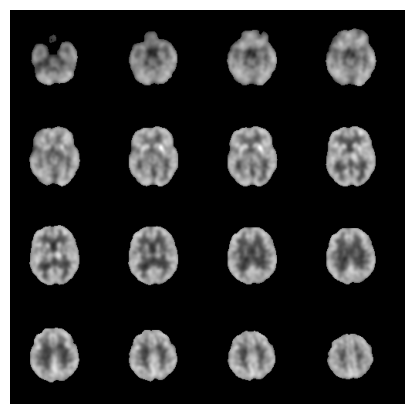

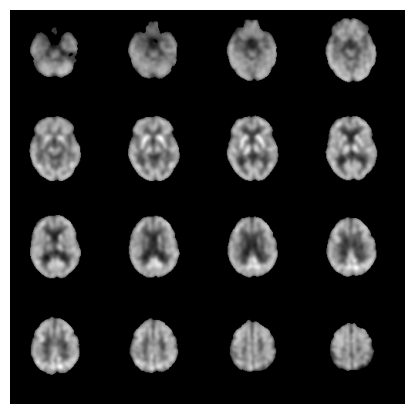

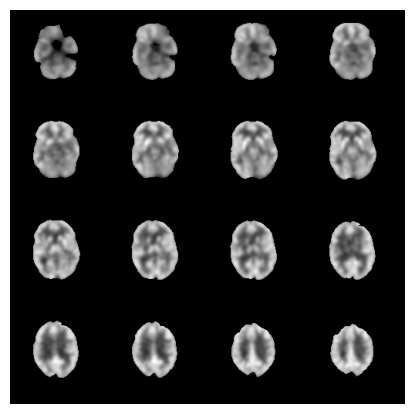

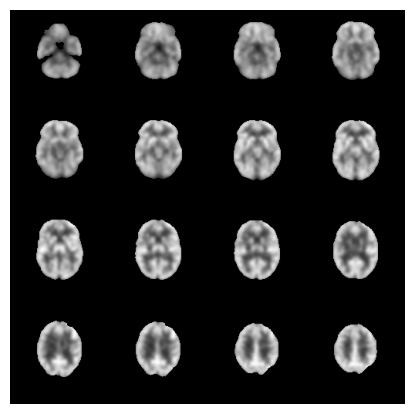

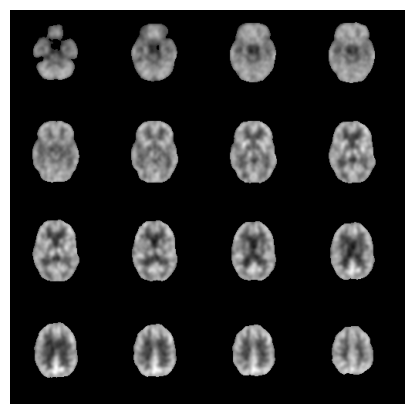

In [142]:
show_images(dataloader)

# Oasis3 (no smoothed)

In [143]:
mean = 3374.4560546875  # son de los previos, recalcular
std = 7053.744253940597 # son de los previos, recalcular
csvFile = '/Users/hugom/PET-IA/Sets/oasis3.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/oasis3-preprocessed-unsmoothed'
oasisTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([mean, mean, mean], [std, std, std])
])
dicti = {
    "AD": 1,
    "CN": 0
}
csv = pd.read_csv(csvFile)
csv['Group'] = 'CN'
dataset = BaseDataset('oasis3', csv, imagesFolder, studyIDLabel = 'StudyID', transform = oasisTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

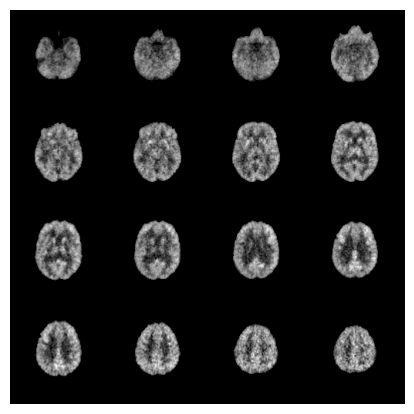

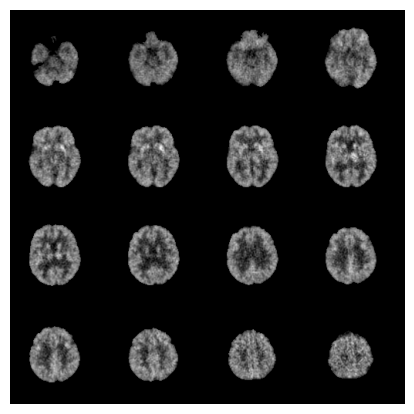

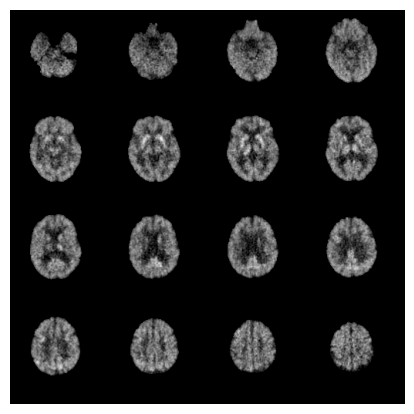

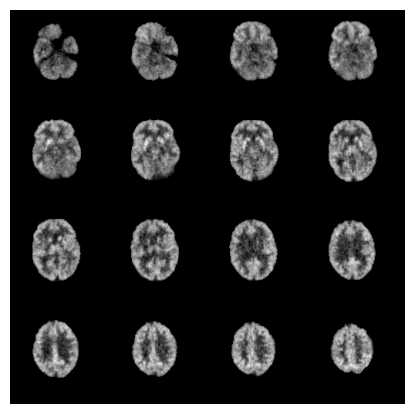

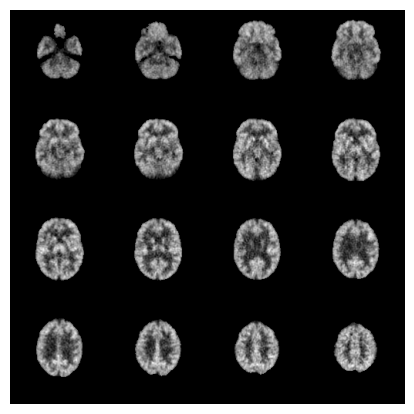

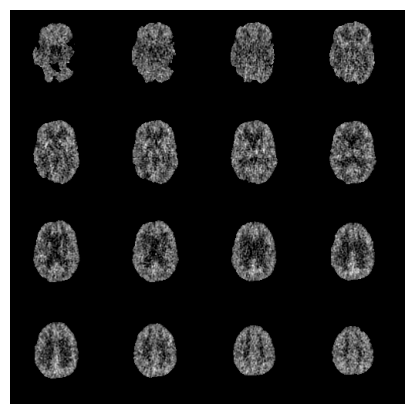

In [144]:
show_images(dataloader)

# Imágenes 3D

## ADNI

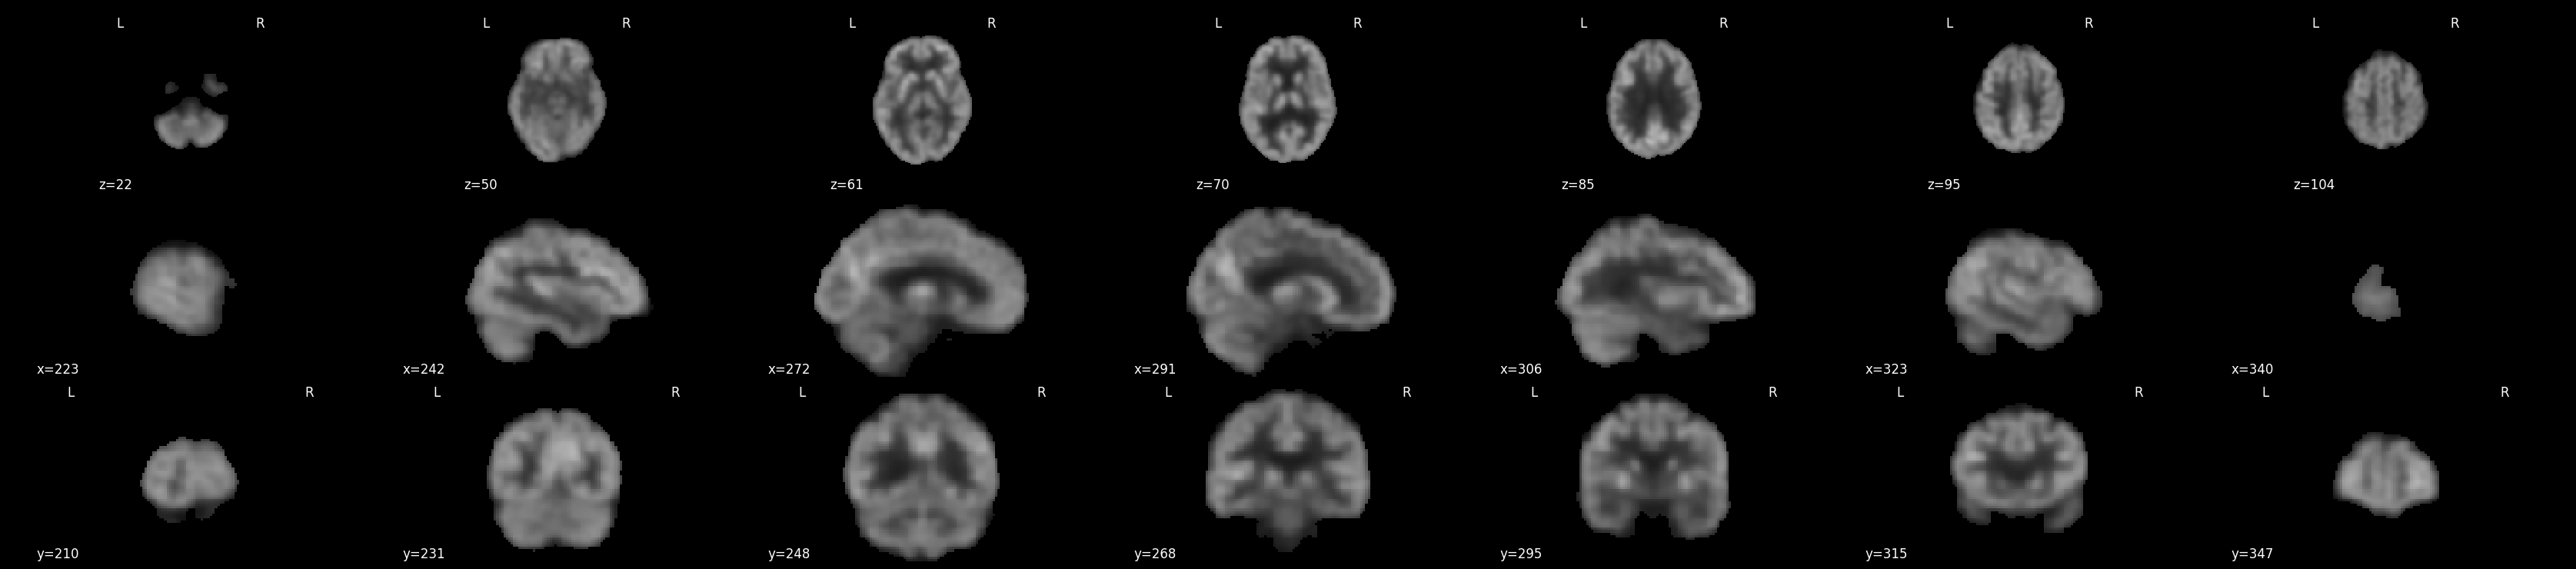

In [51]:
nifti_img = nib.load("/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3/I200191/resampled-normalized.nii")

plotting.plot_anat(anat_img = nifti_img, display_mode = 'mosaic')

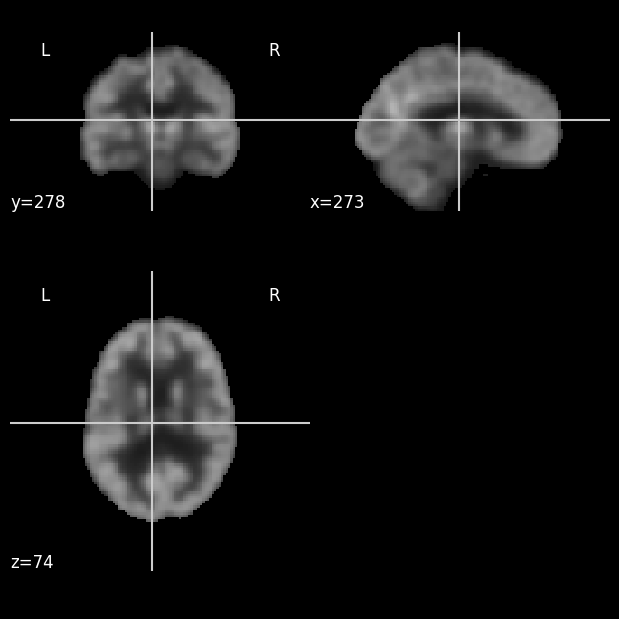

In [52]:
plotting.plot_anat(anat_img = nifti_img, display_mode = 'tiled', cut_coords = (273, 278, 74))

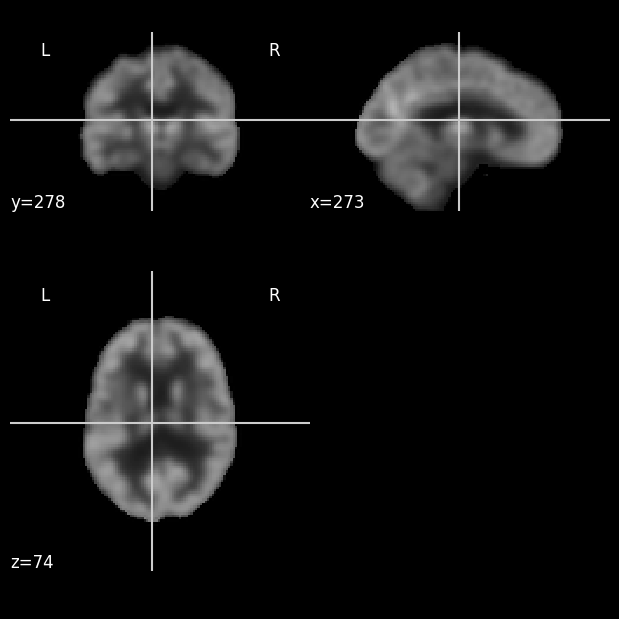

In [53]:
nifti_img = nib.load("/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed-continuous/I200191/resampled-normalized.nii.gz")
plotting.plot_anat(anat_img = nifti_img, display_mode = 'tiled', cut_coords = (273, 278, 74))

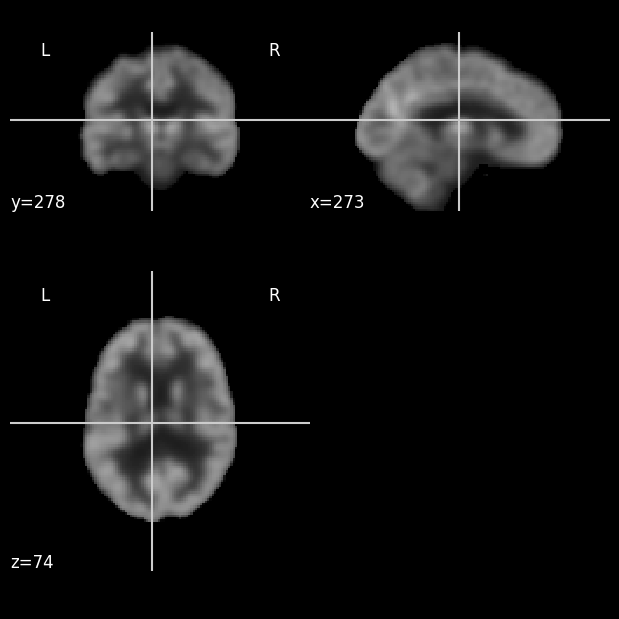

In [54]:
nifti_img = nib.load("/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed-linear/I200191/resampled-normalized.nii.gz")
plotting.plot_anat(anat_img = nifti_img, display_mode = 'tiled', cut_coords = (273, 278, 74))

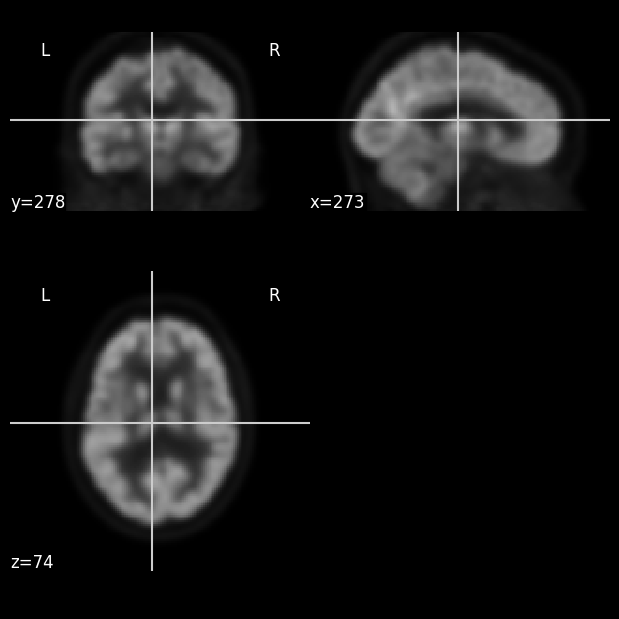

In [55]:
nifti_img = nib.load("/Users/hugom/PET-IA/Full-DBs/ADNI-Full-PostProc/ADNI-8/021_S_2100/Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2010-10-26_11_21_13.0/I200191/ADNI_021_S_2100_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20101028134112319_87_S93717_I200191.nii")
plotting.plot_anat(anat_img = nifti_img, display_mode = 'tiled', cut_coords = (273, 278, 74))

## Fleni100 (Myriam)

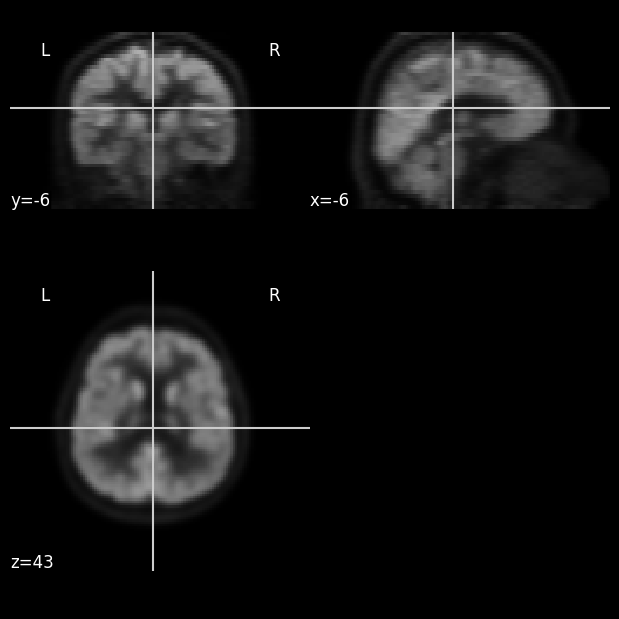

In [67]:
nifti_img = nib.load("/Users/hugom/PET-IA/Full-DBs/fleni-base-myrian/entelai-fleni-pet-base-diferencial/panania/Neuro/fleni_pet_en_base_dif/835bba26-3879ebbf-5e9d4e02-cdef07a1-d9a245ca.zip_container/d42197ef92eb44d98cb977171537595e Anonymized884/9275000551034/PT 3D AC Cerebro fdgdem/835bba26-3879ebbf-5e9d4e02-cdef07a1-d9a245ca.nii.gz")
plotting.plot_anat(anat_img = nifti_img, display_mode = 'tiled', cut_coords = (-6, -6, 43))

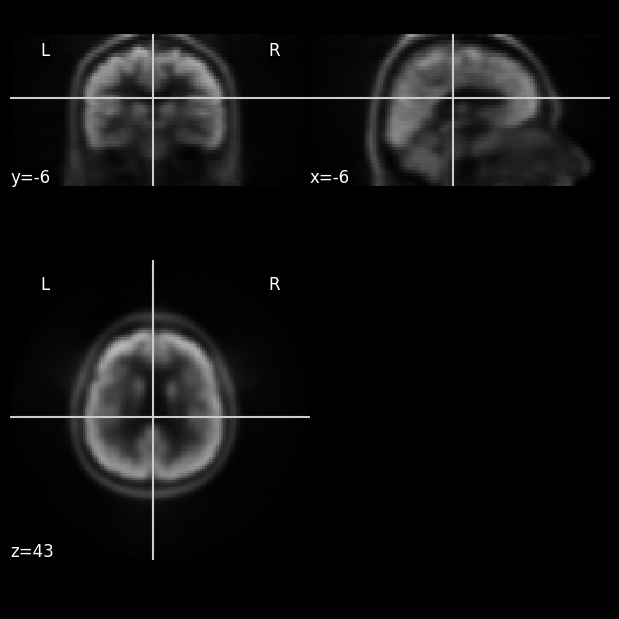

In [65]:
nifti_img = nib.load("/Users/hugom/PET-IA/Full-DBs/fleni-base-myrian/entelai-fleni-pet-base-diferencial/panania/Neuro/fleni_pet_en_base_dif/835bba26-3879ebbf-5e9d4e02-cdef07a1-d9a245ca.zip_container/d42197ef92eb44d98cb977171537595e Anonymized884/9275000551034/PT 3D NAC Cerebro fdgdem/7_3d_nac_cerebro_fdg-dem.nii.gz")
plotting.plot_anat(anat_img = nifti_img, display_mode = 'tiled')

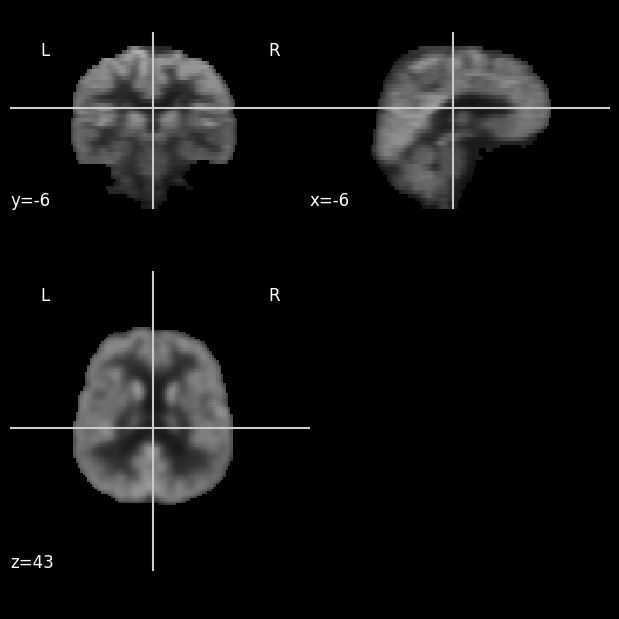

In [66]:
nifti_img = nib.load("/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed3/835bba26-3879ebbf-5e9d4e02-cdef07a1-d9a245ca/resampled-normalized.nii")
plotting.plot_anat(anat_img = nifti_img, display_mode = 'tiled', cut_coords = (-6, -6, 43) )

# Fleni60

En realidad esta imágen puede no ser de Fleni60, chequear una que sí sea

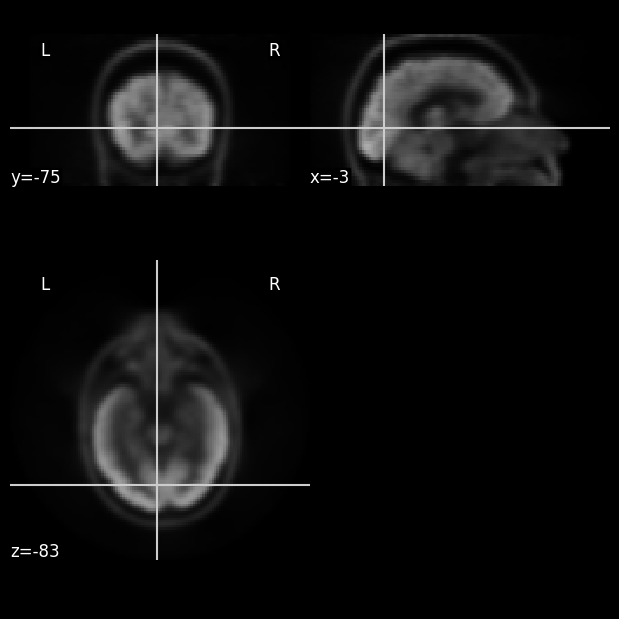

In [62]:
# original NAC
nifti_img = nib.load("/Users/hugom/Downloads/pet_fleni/c33111b1033342828bd931906d906560 Anonymized621/9275000678357/PT 3D NAC Cerebro fdgdem/7_3d_nac_cerebro_fdg-dem.nii.gz")
plotting.plot_anat(anat_img = nifti_img, display_mode = 'tiled', cut_coords = (-3, -75, -83))

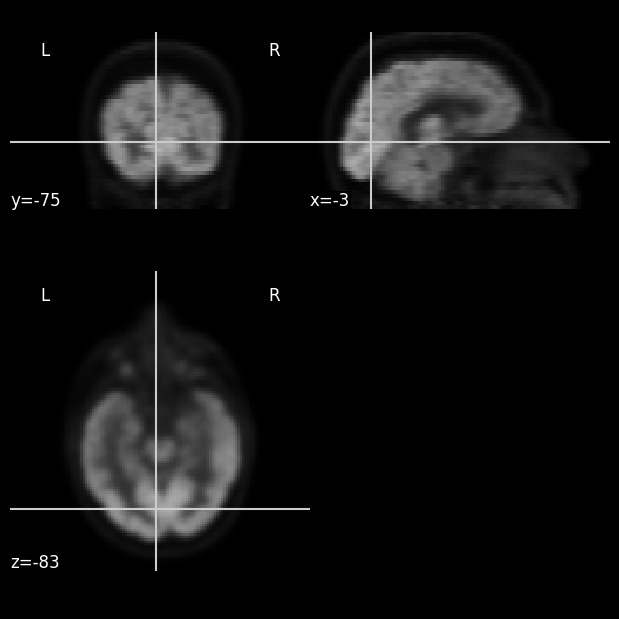

In [61]:
# original NAC
nifti_img = nib.load("/Users/hugom/Downloads/pet_fleni/c33111b1033342828bd931906d906560 Anonymized621/9275000678357/PT 3D AC Cerebro fdgdem/6_3d_ac_cerebro_fdg-dem.nii.gz")
plotting.plot_anat(anat_img = nifti_img, display_mode = 'tiled', cut_coords = (-3, -75, -83))

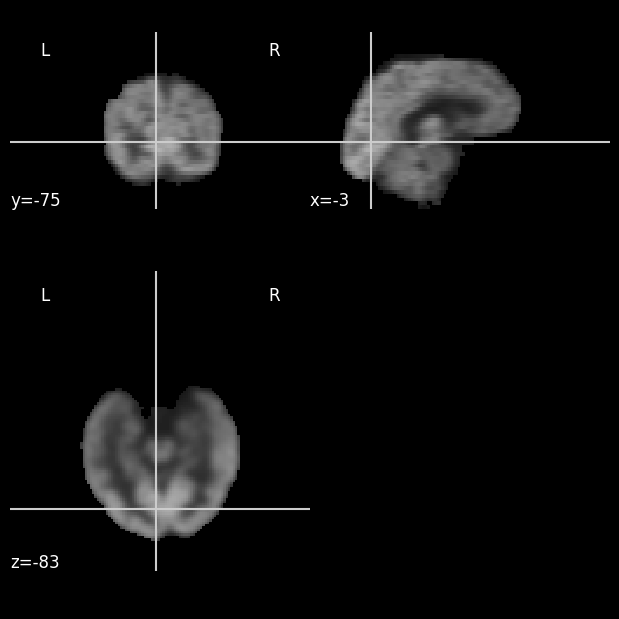

In [63]:
nifti_img = nib.load("/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed4/7861b0e1-238cb043-5de0d771-e9ef9375-25de44c0/resampled-normalized.nii.gz")
plotting.plot_anat(anat_img = nifti_img, display_mode = 'tiled', cut_coords = (-3, -75, -83))

# Data Augmentation

En esta sección voy a guardar (para poder inspeccionar manualmente) como terminan siendo modificadas las imágenes después del data augmentation.

In [60]:
from nilearn.image import resample_img

def resampleNiftiNonIsomorphic(sample, scaleX = 1, scaleY = 1, scaleZ = 1, target_shape = None):
    currX = sample.header['dim'][1]
    currY = sample.header['dim'][2]
    currZ = sample.header['dim'][3]
    
    scaleAffine = np.array([
        [scaleX, 0, 0, 0],
        [0, scaleY, 0, 0],
        [0, 0, scaleZ, 0],
   
        [0, 0, 0, 1],
    ])
    newAffine =  sample.affine @ scaleAffine
    # Usamos nearest porque es mas fiel, no inventa valores, aunque se vea peor
    resampled = resample_img(sample, copy = True, target_affine=newAffine, interpolation='nearest', target_shape = target_shape)
    return resampled

In [61]:
nifti_img = nib.load("/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3/I200191/resampled-normalized.nii")

In [62]:
nifti_img.header["dim"]

array([  3, 128, 128,  77,   1,   1,   1,   1], dtype=int16)

In [64]:
img2 = resampleNiftiNonIsomorphic(nifti_img, scaleZ = 77/47, target_shape = (128, 128, 47))

In [65]:
img2.header["dim"]

array([  3, 128, 128,  47,   1,   1,   1,   1], dtype=int16)

In [66]:
img3 = resampleNiftiNonIsomorphic(img2, scaleZ = 47/77, target_shape = (128, 128, 77))

In [67]:
img3.header["dim"]

array([  3, 128, 128,  77,   1,   1,   1,   1], dtype=int16)

In [10]:
mean = 0.26102542877197266
std = 0.46347398656747363

In [13]:
means = [mean, mean, mean]
stds = [std, std, std]

df = pd.DataFrame(getAllImageIds(), columns = ["ImageDataID"])
df['Group'] = 'AD' # Fake, it doesn't matter

dataAugmentation = {
    "angle": 15,
    "shiftX": 10,
    "shiftY": 10,
    "zoom": 0.12,
    "shear": 0.19634954084936207,
    "collapseYDim": 47
    
}
adniTransforms = torchvision.transforms.Compose([
    Transform3DImage(**dataAugmentation, yDim = 77, augmentation = 'one', verbose=True),
])
dataset = ADNIDataset('adni', df, '/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3', indexOffset = 0, transform = adniTransforms, truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [14]:
i = 0
for images, labels in dataloader:
    image = images[0]
    label = labels[0]
    
    image = image.transpose(2, 1)
    
    image = image.detach().cpu().numpy()
    
    image = nib.Nifti1Image(image, affine=np.eye(4))
    
    nib.save(image, f"image_adni_{i}_{label}")
    
    i = i + 1
    if i > MAX_IMAGES:
        break

Filter chosen: angle
Filter chosen: shiftX
Filter chosen: shiftX
Filter chosen: zoom
Filter chosen: shiftX
Filter chosen: collapseYDim


In [17]:
mean = 3864.730224609375
std = 8282.332521699427
csvFile = '/Users/hugom/PET-IA/Sets/fleni-PET_clasificados60.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed4'
dataAugmentation = {
    # "angle": 15,
    # "shiftX": 10,
    # "shiftY": 10,
    # "zoom": 0.12,
    # "shear": 0.19634954084936207,
    "yDim": 77,
    "shiftZ": 10
}
fleniTransforms = torchvision.transforms.Compose([
    Transform3DImage(**dataAugmentation, resampleZ = 0.610389),
])
dicti = {
    "AD": 1,
    "non-AD": 0
}
dataset = BaseDataset('fleni60', csvFile, imagesFolder, studyIDLabel = 'anon_id', transform = fleniTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Conclusion PET')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
i = 0
for images, labels in dataloader:
    image = images[0]
    label = labels[0]
    
    image = image.transpose(2, 1)
    
    image = image.detach().cpu().numpy()
    
    image = nib.Nifti1Image(image, affine=np.eye(4))
    
    nib.save(image, f"image_fleni_{i}_{label}")
    
    i = i + 1
    if i > MAX_IMAGES:
        break

# Fleni600

In [15]:
mean = 3864.730224609375
std = 8282.332521699427
csvFile = '/Users/hugom/PET-IA/Sets/fleni600_limpio.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed4'
ebrainsTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([mean, mean, mean], [std, std, std])
])
dicti = {
    "AD": 1,
    "non-AD": 0
}
dataset = BaseDataset('fleni600', csvFile, imagesFolder, studyIDLabel = 'anon_id', transform = ebrainsTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Diagnóstico')
fleniDataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

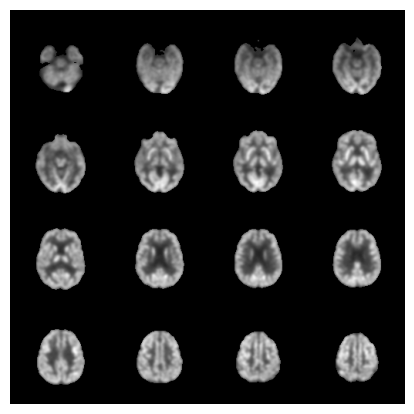

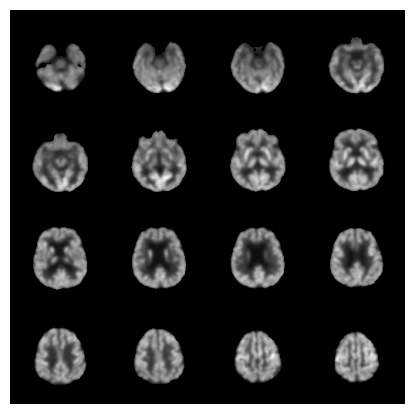

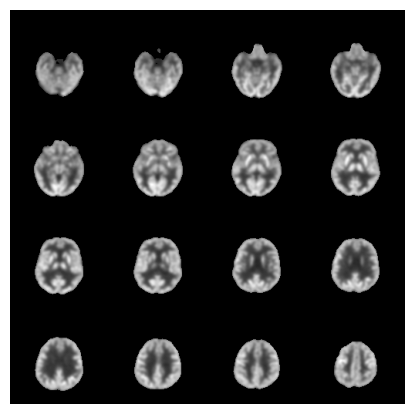

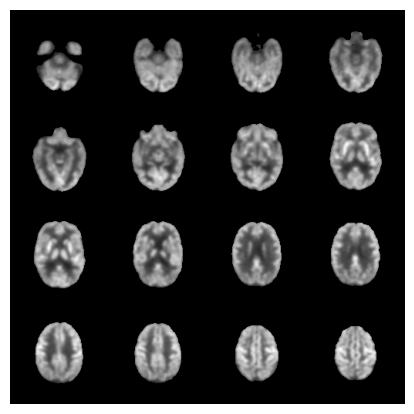

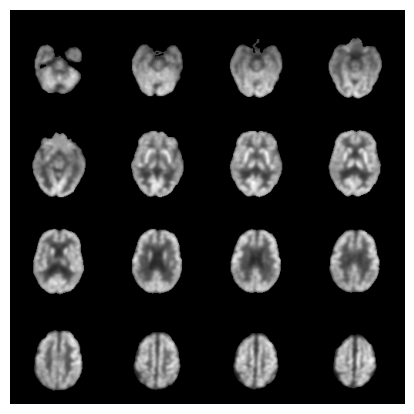

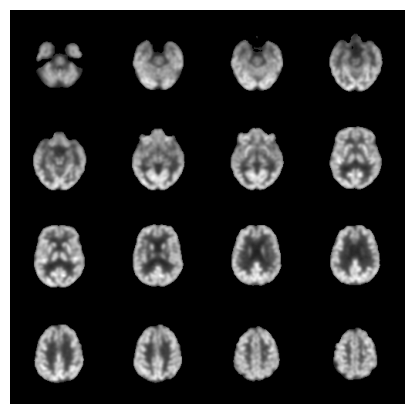

In [16]:
show_images(fleniDataloader, mean, std)